In [1]:
# for loading/processing the images  
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from PIL import Image

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from cellpose import models

# clustering and dimension reduction
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from natsort import natsorted, ns
from skimage.morphology import medial_axis

# Geometry comparison

In [2]:
path = '../rasters/parcelles_18e_reorientees'
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filenames
parcelles = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the list
            parcelles.append(file.name)

In [3]:
#model = VGG16()

model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model_cell = models.Cellpose(model_type='cyto')
channels = [[0,0]]

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def extract_axes(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # Grayscale
    img = img.convert('L')
    # Threshold
    img = img.point( lambda p: 0 if p == 255 else 255 )
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # extract medial axis
    img = medial_axis(img, return_distance=False)
    img = img.astype(int)*255
    img = Image.fromarray(img, 'RGB')
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def extract_flow(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # Grayscale
    img = img.convert('L')
    # Threshold
    img = img.point( lambda p: 0 if p == 255 else 255 )
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # extract medial axis
    masks, flows, styles, diams = model_cell.eval(img, diameter=None, channels=channels)
    img = flows[0]
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features



In [4]:
data = {}

# lop through each image in the dataset
for parcelle in parcelles:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(parcelle, model)
        data[parcelle] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        pass

1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 276ms/step


HDBSCAN()

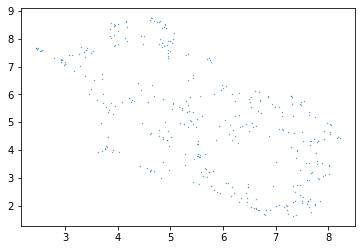

In [13]:
import umap

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# reduce the amount of dimensions in the feature vector
#pca = PCA(n_components=100, random_state=22)
#pca.fit(feat)
#x = pca.transform(feat)

#10, 0.1
x = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(feat)

plt.scatter(x[:, 0], x[:, 1], s=0.1, cmap='Spectral');

# cluster feature vectors
#clustering = KMeans(n_clusters=len(unique_labels),n_jobs=-1, random_state=22)

#clustering = AgglomerativeClustering(n_clusters=40, linkage='complete')

clustering = hdbscan.HDBSCAN()

clustering.fit(x)

In [14]:
# holds the cluster id and the images { id: [images] }
i = 0
groups = {}
parcelles = []

for file, cluster in zip(filenames,clustering.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    if cluster == -1:
        parcelles.append(file)
    i+=1

print(clustering.labels_)

[16  6 -1 -1 15 -1 15 13 -1 15 -1 12 15 -1 10 -1 15  9  8  8  5 15 15 15
 15 -1  5 12 11  3  5 10 -1  3 -1 11  9 -1  2 15  8 15  2 -1 12  3 13  3
  9  4  9 -1 15 -1  9 11  3 -1  3  5  9 13 15  9  9  2 13  4  1 13  9 15
 -1 10  2  2  3 15 -1 15 15  3  8  3  9  3 -1  7  3  8 -1 -1  8 -1 15 12
 14 -1 13 15 15 12 13 15 15 11 15 -1 -1 10 13 15  7  5 -1 -1 16 15 15 15
 -1 15  8 -1  9 15 15 -1 15 15 13  3 15 -1  4  4  4 -1 -1  2 11  6  2  2
  2  9  9 -1  3 12 -1 -1  9 12  8 -1 11 -1 13 -1 -1  5  6  4 14  6 -1 12
  6  9  3  5  8  9 -1  3 -1  0  7  2  1  9  2 13 11 14  2 15 10  2  8 15
 10  5 11 -1 13 13  4  4 15  1  2 -1 13  5  9  8  9 -1  0 15 -1  9 16 15
 15 13  9  7  4 12 15 13  9  8 15  6  8  2 14 -1 15 15 14 11  4  6  5  3
 16 -1  9  0 13 15 13  4  2  0  7 12  6 12 15 13 15 13 -1 14 -1  9  8  1
  4 -1  3  4  5  4  9  2  9  8 15  8 -1  2  6  9  6 10 13 13  9 13 -1  0
 16  9  7  7  9 15  7  7  2  1  8 14  5 -1  8  0  4  0 -1  6  6 -1 15  7
 15 15 15 13  8 -1  8  9 12  0  0  3  4 15 12  5  1

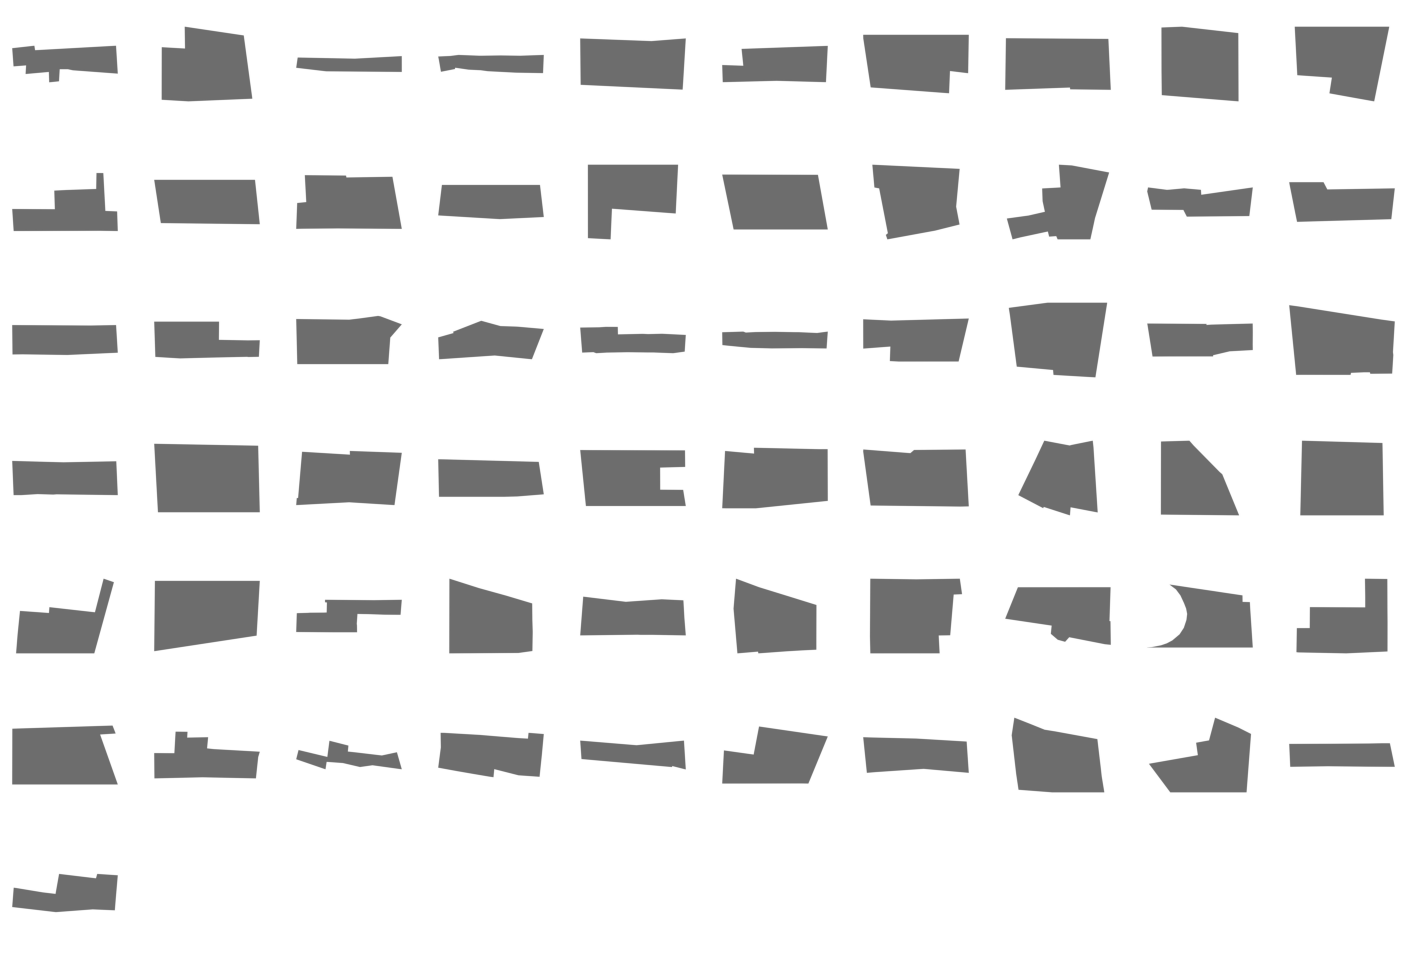

In [34]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 99:
        print(f"Clipping cluster size from {len(files)} to 99")
        files = files[:98]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

view_cluster(-1)